In [1]:
import json
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import keras
from numpy import array
from keras.utils import plot_model
import neurokit2 as nk
import tensorflow as tf
from skimage.restoration import denoise_wavelet
from sklearn.preprocessing import StandardScaler

# Read data from CSV files

In [2]:
def read_csv(filepath):
    f = open(filepath)
    data = json.load(f)
    return data

#ecg = read_csv('Preprocessed_data/ecg/ecg_unfiltered.txt')
ecg_filt = read_csv('Preprocessed_data/ecg/ecg_filtered.txt')

# Remove first and last few minutes of data for cleaning and split it into segments of 10 seconds

In [3]:
#remove first and last few minutes
for patient in ecg_filt:
    ecg_filt[patient] = ecg_filt[patient][5000:700000]
    #ecg[patient] = ecg[patient][5000:763000]

    ecg_filt[patient] = nk.ecg_clean(ecg_filt[patient], sampling_rate=62.475)

In [4]:
duration = int(10*62.4725)
segments_ecg = []

for patient in ecg_filt:
    values = ecg_filt[patient]
    for i in range(0,len(values) - duration + 1, duration):
        segments_ecg.append(values[i : (i + duration)])

# Find quality of each segment
 Assess the quality of the ECG Signal by extracting several signal quality indexes (SQIs): QRS wave power spectrum distribution pSQI, kurtosis kSQI, and baseline relative power basSQI.  It returns a vector containing the quality index classification (Unacceptable, Barely Acceptable or Excellent) of the signal.
 We remove the Invalid signals from our datatset for training the autoencoder

In [6]:
quality = []
for i in range(len(segments_ecg)):
    try:
        quality.append(nk.ecg_quality(segments_ecg[i],
                   sampling_rate = 62.475,
                   method="zhao2018",
                   approach="simple"))
    except:
        quality.append("Invalid Input")

In [7]:
indices = np.where(np.array(quality) != "Invalid Input")[0]

normal_ecg = [segments_ecg[x] for x in indices]

# Split the data into Train test and validation sets
- Train set: 60%
- Test set: 20%
- Validation set: 20%

In [8]:
train_df, val_df = train_test_split(normal_ecg,test_size=0.4,shuffle = True)
test_df, val_df = train_test_split(val_df,test_size=0.5,shuffle = True)

train_df = np.stack(train_df)
val_df = np.stack(val_df)
test_df = np.stack(test_df)

x_train = train_df.reshape(train_df.shape[0],train_df.shape[1], 1)
x_val = val_df.reshape(val_df.shape[0],val_df.shape[1], 1)
x_test = val_df.reshape(test_df.shape[0],test_df.shape[1], 1)

print("Training input shape: ", x_train.shape)
print("Val input shape: ", x_val.shape)
print("Test input shape: ", x_test.shape)

Training input shape:  (11078, 624, 1)
Val input shape:  (3693, 624, 1)
Test input shape:  (3693, 624, 1)


# Define the Autoencoder model

In [9]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        keras.layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Conv1D(
            filters=8, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Conv1DTranspose(
            filters=8, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        keras.layers.Conv1DTranspose(filters=1, kernel_size=5, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss="mae")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 624, 16)           128       
                                                                 
 dropout (Dropout)           (None, 624, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 624, 8)            904       
                                                                 
 conv1d_transpose (Conv1DTr  (None, 624, 16)           912       
 anspose)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 624, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 624, 8)            904       
 Transpose)                                             

# Train the model

In [10]:
history = model.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val, x_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/10
22/22 [==============================] - 10s 389ms/step - loss: 0.0435 - val_loss: 0.0168
Epoch 2/10
22/22 [==============================] - 10s 441ms/step - loss: 0.0172 - val_loss: 0.0070
Epoch 3/10
22/22 [==============================] - 13s 598ms/step - loss: 0.0124 - val_loss: 0.0052
Epoch 4/10
22/22 [==============================] - 10s 447ms/step - loss: 0.0108 - val_loss: 0.0063
Epoch 5/10
22/22 [==============================] - 9s 405ms/step - loss: 0.0098 - val_loss: 0.0068
Epoch 6/10
22/22 [==============================] - 9s 401ms/step - loss: 0.0091 - val_loss: 0.0103
Epoch 7/10
22/22 [==============================] - 9s 405ms/step - loss: 0.0090 - val_loss: 0.0065
Epoch 8/10
22/22 [==============================] - 9s 417ms/step - loss: 0.0082 - val_loss: 0.0068


# Check the model
#### The model is checked first on the training data to see if it is learning the waveform correctly.

347/347 [==============================] - 3s 8ms/step


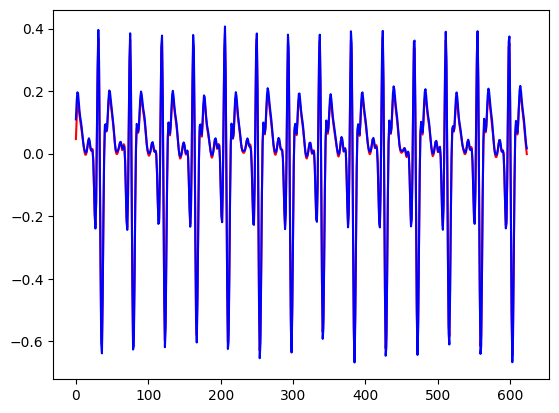

In [11]:
x_train_pred = model.predict(x_train)

# Checking how the first sequence is learnt
plt.plot(x_train_pred[20], color="red")
plt.plot(x_train[20], color="blue")

plt.show()

# Test the model
#### The model is tested on the test data.

The histogram showing the reconstruction losses is plotted. Segments with high reconstruction loss are deemed to be very different from the learned pattern and hence classified as anomalies

116/116 [==============================] - 1s 8ms/step


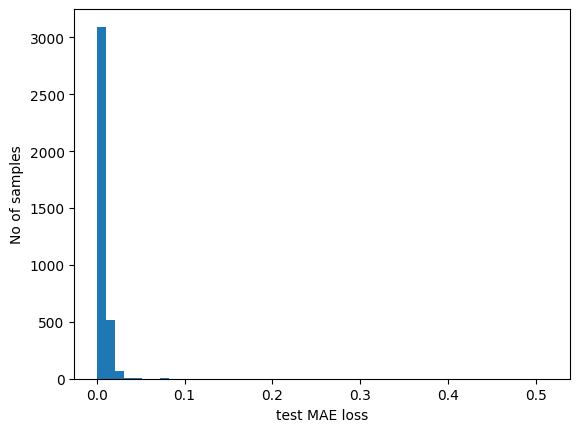

In [12]:
x_test_pred = model.predict(x_test)

# Get test MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


# Plot an anomalous segment

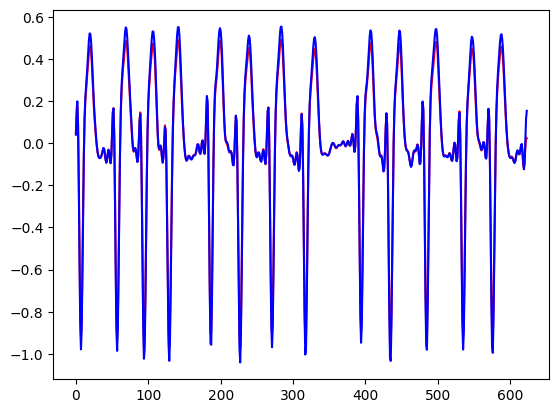

In [14]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > 0.02

patient_num = 1

# Checking how the first sequence is learnt
plt.plot(x_test_pred[list(np.where(anomalies)[0])[patient_num]], color="red")
plt.plot(x_test[list(np.where(anomalies)[0])[patient_num]], color="blue")

plt.show()